In [1]:
import matplotlib.pyplot as plt
# opencv
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Splitting data because flow directory expects it in that manner

In [137]:
import os
print(os.getcwd())


c:\Users\Zehra\Desktop\CV\Classifiers\Weather_Pred


### Checking the datasets and paths

In [119]:
dew_img = cv2.imread(r'D:\DATA_FOR_CV\DATA\Weather_dataset\dew\2208.jpg')

type(dew_img)

numpy.ndarray

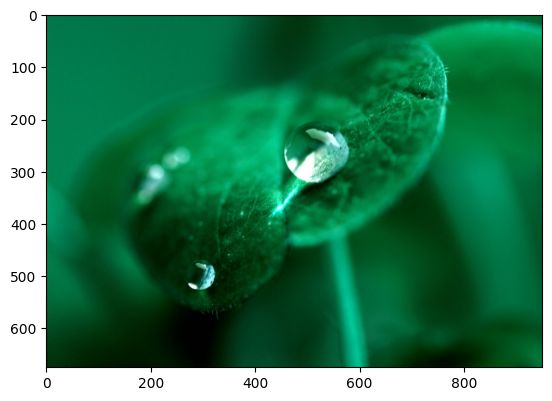

In [122]:
dew_img =cv2.cvtColor(dew_img, cv2.COLOR_BGR2RGB)
plt.imshow(dew_img)

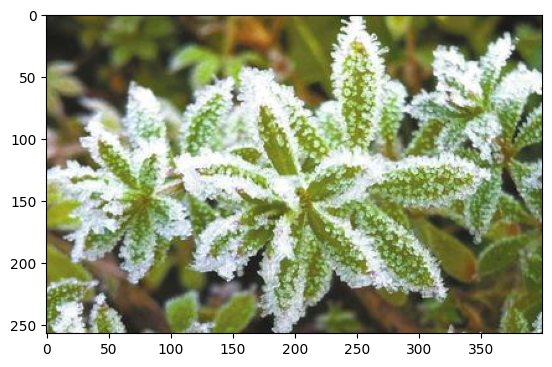

In [120]:
frost_img =cv2.cvtColor(cv2.imread(r'D:\DATA_FOR_CV\DATA\Weather_dataset\frost\3600.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(frost_img)

In [85]:
import os

# Path to your main dataset directory (train, val, or test)
dataset_dir = r'D:\DATA_FOR_CV\DATA\Weather_dataset'  # change to val or test if needed

total_images = 0

# Loop through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len([
            img for img in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, img))
        ])
        print(f"{class_name}: {image_count} images")
        total_images += image_count

print(f"\nTotal images in '{dataset_dir}': {total_images}")


dew: 698 images
fogsmog: 851 images
frost: 475 images
glaze: 639 images
hail: 591 images
lightning: 377 images
rain: 526 images
rainbow: 232 images
rime: 1160 images
sandstorm: 692 images
snow: 621 images

Total images in 'D:\DATA_FOR_CV\DATA\Weather_dataset': 6862


In [88]:
total_images*0.1*0.1

68.62

### Splitting for flow directory

In [89]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set base directory
base_data_dir = r'D:\DATA_FOR_CV\DATA\Weather_dataset'
train_dir = os.path.join(base_data_dir, 'train')
val_dir = os.path.join(base_data_dir, 'val')
test_dir = os.path.join(base_data_dir, 'test')

# Create required folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class
for class_name in os.listdir(base_data_dir):
    class_path = os.path.join(base_data_dir, class_name)

    # Skip train/val/test folders or non-directories
    if not os.path.isdir(class_path) or class_name in ['train', 'val', 'test']:
        continue

    images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

    # Split: 80% train, 10% val, 10% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Create class-specific folders and copy images
    for folder, image_set in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        for img in image_set:
            shutil.copy(os.path.join(class_path, img), os.path.join(class_folder, img))

print("✅ Dataset successfully split into 80% train, 10% val, and 10% test.")




✅ Dataset successfully split into 80% train, 10% val, and 10% test.


### Augmentation

In [138]:
train_image_gen= ImageDataGenerator(
                              # normalize
                              rescale=1/255, 
                              rotation_range=30, 
                              width_shift_range=0.1, 
                              shear_range=0.9, 
                            zoom_range=0.2, 
                              horizontal_flip=True, 
                              height_shift_range=0.1)

In [139]:
train_set = train_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\train')

Found 5484 images belonging to 11 classes.


In [153]:
val_image_gen = ImageDataGenerator(rescale=1/255)

### Applying the image gens and prep data for model

In [144]:

train_img_gen = train_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\train',
                                              target_size = (224,224)
                                              , batch_size=16,
                                              class_mode = 'sparse')

Found 5484 images belonging to 11 classes.


In [154]:

val_image_gen = val_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\val',
                                              target_size = (224,224)
                                              , batch_size=16,
                                              class_mode = 'sparse')

Found 686 images belonging to 11 classes.


In [ ]:
    test_image_gen = ImageDataGenerator(rescale=1./255)

    test_img_gen = test_image_gen.flow_from_directory(
        r'D:\DATA_FOR_CV\DATA\Weather_dataset\test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='sparse',
        shuffle=False  # Important for consistent evaluation, especially with confusion matrix etc.
    )


Found 692 images belonging to 11 classes.


### Model

In [156]:
model = Sequential()

# first conv layer
model.add(Conv2D(filters=20, kernel_size=(4,4), activation='relu', input_shape=(224,224,3)))

# second conv layer

model.add(Conv2D(filters=40, kernel_size=(4,4), activation='sigmoid'))


# third conv layer

model.add(Conv2D(filters=60, kernel_size=(6,6), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())

# dense layers ANN
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))


#output
model.add(Dense(11, activation='softmax'))

In [157]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 221, 221, 20)   │           980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 218, 218, 40)   │        12,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 213, 213, 60)   │        86,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 106, 106, 60)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 674160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │    86,292,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,401,859 (329.60 MB)

 Trainable params: 86,401,859 (329.60 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics =['accuracy'])

In [161]:
result = model.fit(train_img_gen
                   ,epochs = 10
                   ,steps_per_epoch = train_img_gen.samples // train_img_gen.batch_size
                    ,validation_data = val_image_gen
                 ,validation_steps =6
                 )

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.1359 - loss: 2.3798 - val_accuracy: 0.1771 - val_loss: 2.3527
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.1871 - loss: 2.3539 - val_accuracy: 0.1979 - val_loss: 2.3290
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.2324 - loss: 2.3073 - val_accuracy: 0.2188 - val_loss: 2.2814
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.1823 - loss: 2.3304 - val_accuracy: 0.1354 - val_loss: 2.3508
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.1646 - loss: 2.3450 - val_accuracy: 0.1458 - val_loss: 2.3646
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.1869 - loss: 2.3289 - val_accuracy: 0.1458 - val_loss: 2.3631
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.1610 - loss: 2.3301 - val_accuracy: 0.1562 - val_loss: 2.3510
Epoch 8/10
35/44 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.1666 - loss: 2.3243

c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.1683 - loss: 2.3225 - val_accuracy: 0.1146 - val_loss: 2.3479
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.1565 - loss: 2.3332 - val_accuracy: 0.2396 - val_loss: 2.2899
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.1932 - loss: 2.3115 - val_accuracy: 0.1562 - val_loss: 2.3395


In [168]:
print(train_img_gen.class_indices)

{'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


In [169]:
print(val_image_gen.class_indices)

{'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


### Training another model

- Changed the sigmoid thing in layer 2
- Added more maxpooling

In [178]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model2.add(MaxPool2D(2,2))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPool2D(2,2))

model2.add(Conv2D(128, (3,3), activation='relu'))
model2.add(MaxPool2D(2,2))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(11, activation='softmax'))


c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [179]:
model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,379 (42.61 MB)

 Trainable params: 11,170,379 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [180]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics =['accuracy'])

In [182]:
result2 = model2.fit(train_img_gen
                   ,epochs = 10
                   ,steps_per_epoch = 44
                    ,validation_data = val_image_gen
                 ,validation_steps = 6
                 )

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 717ms/step - accuracy: 0.2582 - loss: 2.1839 - val_accuracy: 0.4167 - val_loss: 2.1596
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 711ms/step - accuracy: 0.3151 - loss: 2.0441 - val_accuracy: 0.3229 - val_loss: 1.8381
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 671ms/step - accuracy: 0.3648 - loss: 1.7642 - val_accuracy: 0.4583 - val_loss: 1.6572
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 718ms/step - accuracy: 0.4154 - loss: 1.7146 - val_accuracy: 0.4792 - val_loss: 1.4908
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 702ms/step - accuracy: 0.4198 - loss: 1.7560 - val_accuracy: 0.4479 - val_loss: 1.5078
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 623ms/step - accuracy: 0.4549 - loss: 1.6725 - val_accuracy: 0.4792 - val_loss: 1.5574
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 614ms/step - accuracy: 0.4711 - loss: 1.6577 - val_accuracy: 0.4479 - val_loss: 1.4928
Epoch 8/10
35/44 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step - accuracy: 0.4934 - loss: 1.4703

c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step - accuracy: 0.5002 - loss: 1.4634 - val_accuracy: 0.6562 - val_loss: 1.1607
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 646ms/step - accuracy: 0.5065 - loss: 1.4375 - val_accuracy: 0.5833 - val_loss: 1.2277
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 593ms/step - accuracy: 0.5334 - loss: 1.4226 - val_accuracy: 0.5729 - val_loss: 1.2236


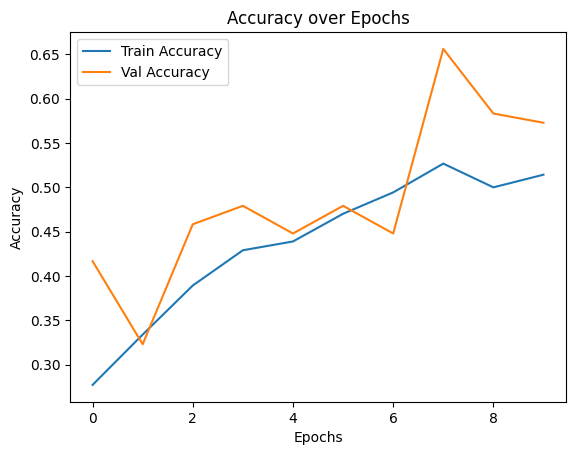

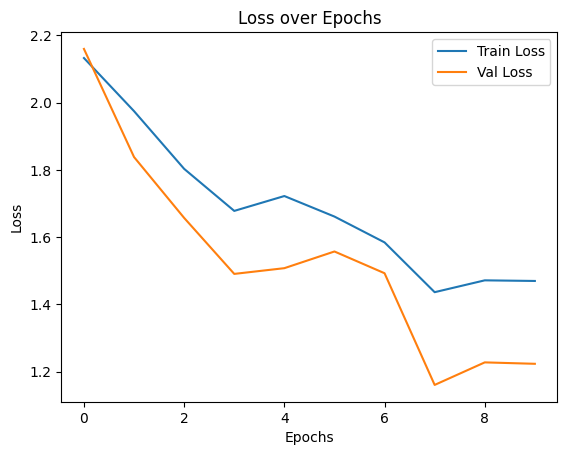

In [183]:
plt.plot(result2.history['accuracy'], label='Train Accuracy')
plt.plot(result2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(result2.history['loss'], label='Train Loss')
plt.plot(result2.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step
Test Accuracy: 0.5910404624277457
Classification Report:

              precision    recall  f1-score   support

         dew       0.71      0.86      0.77        70
     fogsmog       0.82      0.73      0.77        86
       frost       0.40      0.35      0.38        48
       glaze       0.29      0.33      0.31        64
        hail       0.65      0.22      0.33        60
   lightning       0.70      0.79      0.74        38
        rain       0.54      0.55      0.54        53
     rainbow       0.75      0.38      0.50        24
        rime       0.52      0.76      0.62       116
   sandstorm       0.91      0.86      0.88        70
        snow       0.37      0.30      0.33        63

    accuracy                           0.59       692
   macro avg       0.60      0.56      0.56       692
weighted avg       0.60      0.59      0.58       692



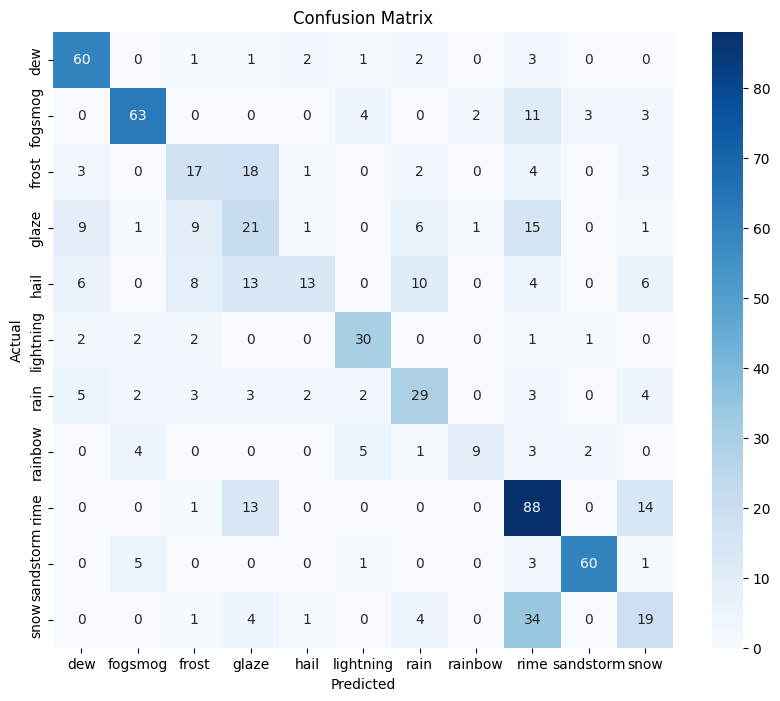

In [185]:


# Predict
y_pred_probs = model2.predict(test_img_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_img_gen.classes

print("Test Accuracy:", accuracy_score(y_true, y_pred))

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_img_gen.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_img_gen.class_indices.keys(), yticklabels=test_img_gen.class_indices.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


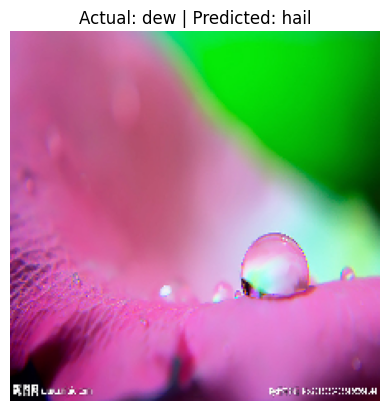

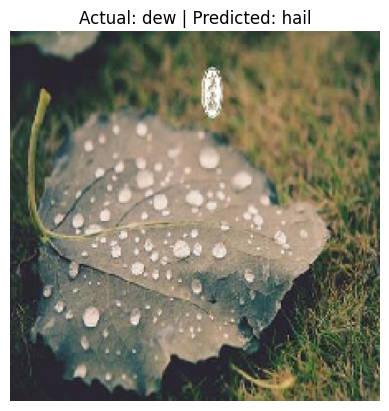

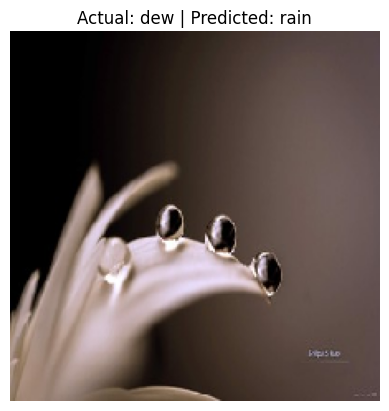

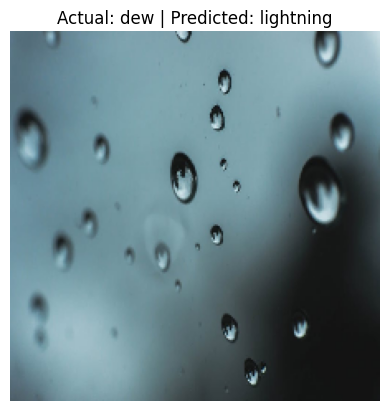

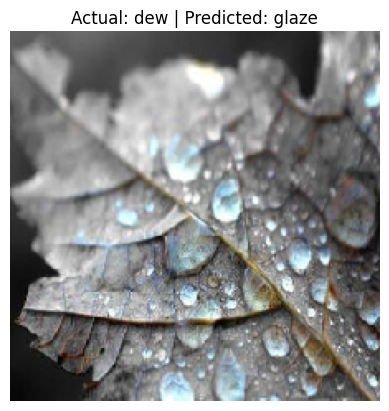

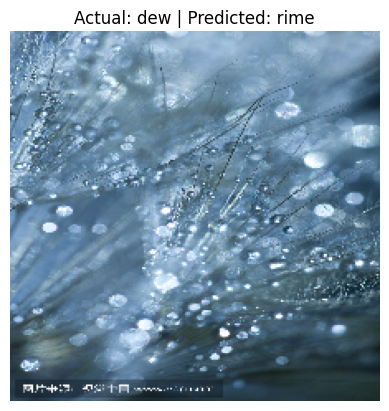

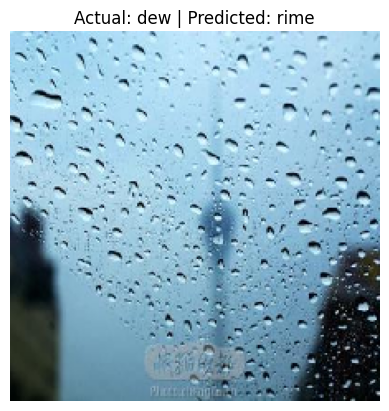

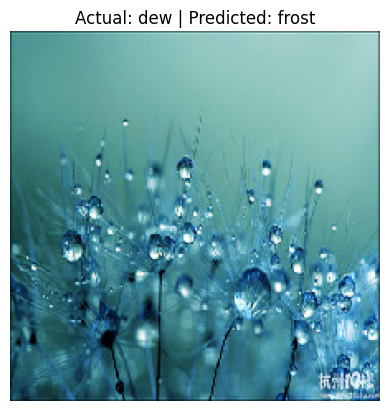

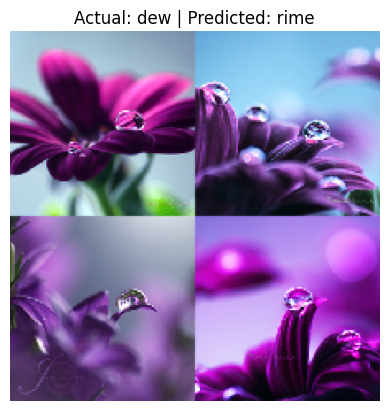

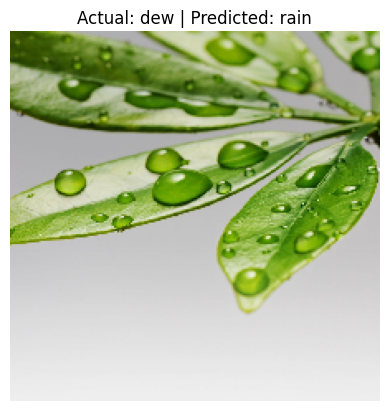

In [188]:
# Get filenames
filenames = test_img_gen.filepaths

# Find misclassified indices
misclassified_idx = np.where(y_pred != y_true)[0]

for i in misclassified_idx[:10]:
    img = image.load_img(filenames[i], target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Actual: {list(test_img_gen.class_indices.keys())[y_true[i]]} | Predicted: {list(test_img_gen.class_indices.keys())[y_pred[i]]}")
    plt.axis('off')
    plt.show()


### Using a pretrained model

In [191]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


In [192]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(11, activation='softmax')(x)  # 11 classes

pretrained_model = Model(inputs=base_model.input, outputs=predictions)


In [194]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [196]:
history = model.fit(
    train_img_gen,
    epochs=10,
    steps_per_epoch=44,
    validation_data=val_image_gen,
    validation_steps=6
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.1670 - loss: 2.3351 - val_accuracy: 0.1979 - val_loss: 2.3102
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.1766 - loss: 2.3083 - val_accuracy: 0.1458 - val_loss: 2.3272
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.1591 - loss: 2.3361 - val_accuracy: 0.0938 - val_loss: 2.3804
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.1761 - loss: 2.3040 - val_accuracy: 0.1250 - val_loss: 2.3162
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.1668 - loss: 2.3360 - val_accuracy: 0.1771 - val_loss: 2.2555
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.1693 - loss: 2.3266 - val_accuracy: 0.2083 - val_loss: 2.2845
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.1777 - loss: 2.3196 - val_accuracy: 0.1562 - val_loss: 2.3292
Epoch 8/10
35/44 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.1371 - loss: 2.3851

c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.1423 - loss: 2.3768 - val_accuracy: 0.1042 - val_loss: 2.3821
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.1876 - loss: 2.3312 - val_accuracy: 0.2188 - val_loss: 2.3013
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.1470 - loss: 2.3473 - val_accuracy: 0.1771 - val_loss: 2.3453
